# Regresión

Supongamos que deseamor aproximar una función arbitrariamente f(x) haciendo uso de un perceptrón multicapa. ¿En qué modo afecta el número de neuronas en la capa intermedia a la calidad de la aporoximación?

Propongamos como ejemplo la función de una dimensión:

In [12]:
using GLMakie
using Latexify

In [21]:
f(x) = x / 2 * (sin(20 * x) - cos(20 * x / 3))

f (generic function with 1 method)

In [14]:
x = -1:0.02:1
y = f.(x)

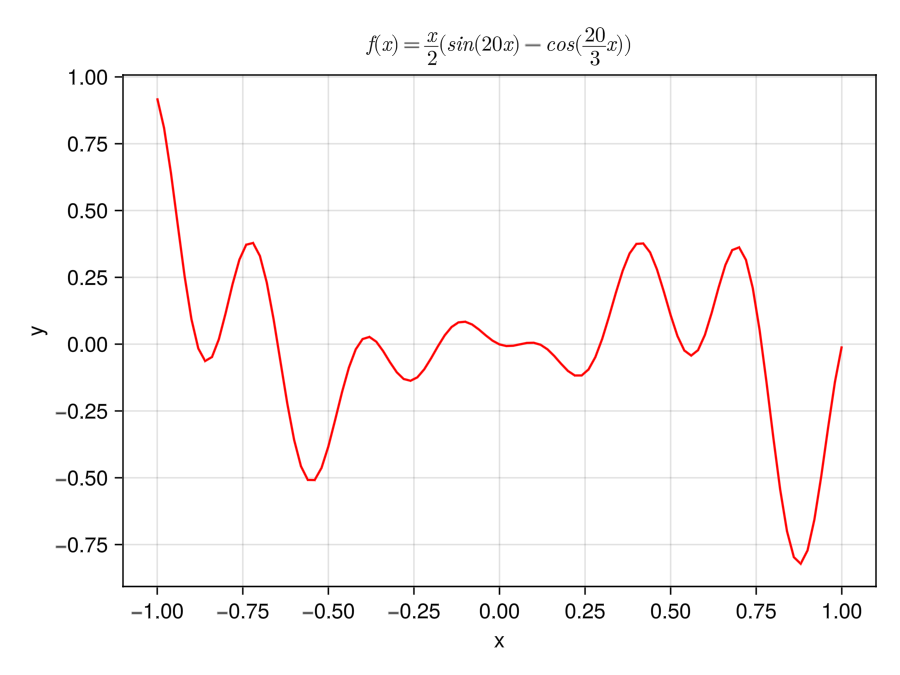

In [28]:
fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel = "x",
    ylabel = "y",
    title = L"f(x) = \frac{x}{2} (sin(20x) - cos(\frac{20}{3}x))",
    yticks = -1:0.25:1,
    xticks = -1:0.25:1,
)
lines!(ax, x, y, color=:red)
fig

In [39]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, logitcrossentropy, throttle, params
using Base.Iterators:repeated
using CUDA
using MLDatasets
using Random


Random.seed!(1)

if has_cuda()
    @info "CUDA is on"
    CUDA.allowscalar(false)
end

Base.@kwdef mutable struct Args
    rate::Float64 = 3e-4
    batchsize::Int = 1024
    epochs::Int = 10
    device::Function = gpu
end




Args

In [35]:
x_vec = reshape(x, 1, :)
typeof(x_vec)

Base.ReshapedArray{Float64, 2, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Tuple{}}

In [41]:
X = Flux.flatten(x_vec)
typeof(X)

Base.ReshapedArray{Float64, 2, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Tuple{}}

In [42]:
y_vec = reshape(y, 1, :)
Y = Flux.flatten(y_vec)

1×101 Matrix{Float64}:
 0.920156  0.808911  0.64152  0.446654  …  -0.311938  -0.140587  -0.00721123

In [44]:

"""
Recibe el número de neuronas en la capa oculta y construye el modelo de repeated
neuronal en capas, en donde tenemoe una capa lineal seguida de la aplicacion
sigmoide y despues otra capa lineal
"""
function build_model(s1)
    return Chain(
        Dense(1, s1, σ),
        Dense(s1, 1)
    )
end

"""
Evaluación de la red sobre la entrada x
usando alimentación hacia adelante para los pesos actuales
"""
function forward(model, x)
    return model(x)
end

"""
Función que realiza el entrenamiento: Intentará reducir la distancia entre
los valores que salen de la red y lo que deseamos modificando los pesos de la
red.
"""
function train(; kws...)
    args = Args(; )

    # Load Data
    train_data, test_data = getdata(args)

    # Construir el modelo
    model = build_model()
    train_data = args.device.(train_data)
    test_data = args.device.(test_data)
    model = args.device(model)
    loss(x, y) = Flux.mse(model(x), y)

    # Traiuning
    evalcb = () -> @show(loss_all(train_data, m))
    opt = Adam(args.rate)
    for epoch in 1:args.epochs
        @info "Epoch $epoch"
        Flux.train!(loss, params(model), train_data, opt, cb = throttle(evalcb, 30))
    end

    @show accuracy(train_data, model)
    @show accuracy(test_data, model)

end

train

In [ ]:
"""
Grafica la evolución de la función de error y la función que evalúa
actualmente la red.
"""
function grafica_entrenamiento(x, e, y_pred)
    fig = Figure()
    axez = [
        Axis(
            fig[1, 1],
            xlabel = "pasos",
            ylabel = "error",
            title = "Evolución de la red",
            yticks = 0:0.2:1,
            xticks = 0:0.2:1,
        ),
        Axis(
            fig[1, 2],
            xlabel = "x",
            ylabel = "y",
            title = "Predicción",
            yticks = 0:0.2:1,
            xticks = 0:0.2:1,
        ),
    ]

    lines!(axez[1], x, e, color=:red)
    lines!(axez[2], x, y_pred, color=:red)

    fig
end

In [51]:
learning_rates = Dict(
    2 => 0.025,
    5 => 0.0015,
    50 => 0.001,
    500 => 0.0005,
    5000 => 0.0001)

num_steps = Dict(
    2 => 1000,
    5 => 1000,
    50 => 1000,
    500 => 1000,
    5000 => 1000)

function aproxima(opcion)
    learning_rate = learning_rates[opcion]
    n_steps = num_steps[opcion]

    model = build_model(opcion)
    y_pred, e = train(X, Y, model, learning_rate, n_steps)
    
    grafica_entrenamiento(1:n_steps, e, y_pred)
end

aproxima(2)

LoadError: MethodError: no method matching train(::Base.ReshapedArray{Float64, 2, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Tuple{}}, ::Matrix{Float64}, ::Chain{Tuple{Dense{typeof(σ), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, ::Float64, ::Int64)

In [ ]:
learning_rate_slider = Slider(range=7:0.0001:, startvalue=0.001)
num_steps_slider = Slider(range=100:100:1000, startvalue=100)

function entrena_mas(learning_rate, num_steps)
    n_steps = int(num_steps)
    model = build_model(2)
    y_pred, e = train(X, Y, model, learning_rate, n_steps)

    grafica_entrenamiento(1:n_steps, e, y_pred)
end

entrena_mas(0.001, 100)